# HW02 Machine Learning

## Table Of Content
##### 1. [Data](#data-header)

1. [Data Collection](#data-collection)
2. [Understanding the Data](#understand-data)
3. [Data Cleaning](#data-cleaning)

##### 2. [Data Visualization](#viz-header)

1. [Intrestings graphs](#intresting)
2. [Colerration matrix](#col-matrix)
3. [Correlation between features](#feat-matrix)

##### 3. [Clustering -  Demographic analysis](#clustering-header)

1. [Kmeans](#kmeans)
2. [GMM](#gmm)

##### 4. [Random Forest - Predict number of valid votes](#forest-header)

##### 5. [Adaboost - Predict number of voters](#adaboost-header)

##### 6. [Predict Disqualified Votes](#dis-header)


In [ ]:
'''
NOTE about the files
our files as we read them into this notebook are saved in this hierarchy

data/
├── bycode2018.xlsx
├── index 2018.xlsx
├── coord.csv
│
├── 21/
│   ├── expb.csv
│   ├── expc.csv
├── 22/
│   ├── expb.csv
│   ├── expc.csv
├── 23/
│   ├── expb.csv
│   ├── expc.csv

Where coord.csv is a new csv file we included which is similar to the bycode.xlsx but from 4 years ago, 
we needed it since it has exact loocation of each settlement which allowed us to draw them on Israel's map
the csv file will be added with the hw submission

All other files were not changed we used them as they were when we downloaded them.
'''

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
import plotly

import re
import folium
import random
from pyproj import Proj, transform
from scipy.spatial.distance import cdist
import seaborn as sns
from branca.element import Template, MacroElement
plt.style.use('fivethirtyeight')

import sklearn
from sklearn import metrics
from sklearn import mixture
from sklearn.cluster import SpectralClustering, DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

random.seed(1234)

<hr>

# 1. Data <a class="anchor" id="data-header"></a>
## 1.1. Data Collection <a class="anchor" id="data-collection"></a>

In [3]:
# Get all csv's

data_path = r'data\\21'
c21 = pd.read_csv(os.path.join(data_path, "expc.csv"), header=0)
b21 = pd.read_csv(os.path.join(data_path, "expb.csv"), header=0)

data_path = r'data\\22'
c22 = pd.read_csv(os.path.join(data_path, "expc.csv"), header=0)
b22 = pd.read_csv(os.path.join(data_path, "expb.csv"), header=0)

data_path = r'data\\23'
c23 = pd.read_csv(os.path.join(data_path, "expc.csv"), header=0)
b23 = pd.read_csv(os.path.join(data_path, "expb.csv"), header=0)

data_path = r'data'
bycode = pd.read_excel(os.path.join(data_path, "bycode2018.xlsx"), header=0)
index = pd.read_excel(os.path.join(data_path, "index 2018.xlsx"))

## 1.3. Data Cleaning <a class="anchor" id="data-cleaning"></a>

In each section we need different data based on the requested analysis, to limit the chance of one "changing" the data of another section we used new dataframes for each section so the cleansing part is in methods that we can call upon each time. 

In [4]:
# So we wont have to drop it each time
c21 = c21.drop(['Unnamed: 37'], axis=1)

def process_bycode(df):
    '''
    this method fixes values that are "out of place" like שנת ייסוד = 0 and 
    fills nulls with average or zeros depending on the column.
    '''
    
    df = df.drop(['יהודים ואחרים', 'שנת ייסוד',
                  'שיוך מטרופוליני', 'תעתיק', 'אשכול רשויות מקומיות', 'קואורדינטות', 'שנה'], axis=1)
    # Fill out missing numbers
    df["גובה"].fillna("0",inplace = True)
    df["דת יישוב"].fillna("0",inplace = True)
    
    '''Population fill missing rows with average of all others'''
    df['סך הכל אוכלוסייה 2018'] = df['סך הכל אוכלוסייה 2018'].fillna(np.round(df['סך הכל אוכלוסייה 2018'].mean()))
    
    '''Number of arabs and jews
    fill missing data with 80% or population for jews and 20% for arabs.'''
    for index,row in df.iterrows():
        if np.isnan(row["ערבים"]):
            df.at[index,"ערבים"] = round(df.at[index,'סך הכל אוכלוסייה 2018']*0.2)
        if np.isnan(row["מזה: יהודים"]):
            df.at[index,"מזה: יהודים"] = round(df.at[index,'סך הכל אוכלוסייה 2018']*0.8)
    """ השתייכות ארגונית """       
    df["השתייכות ארגונית"].fillna("19",inplace = True)
    """ ועדת תכנון """       
    df["ועדת תכנון"].fillna("0",inplace = True)
    """ צורת יישוב """
    for index,row in df.iterrows():
        if row["צורת יישוב שוטפת"] in [120,130,140,150,250,160,260,170,270,180,280,190,191,192,193,290]:
            # יישוב עירוני
            df.at[index,"צורת יישוב שוטפת"] = 100
        elif row["צורת יישוב שוטפת"] in [310,320,330,340,440,370,350,450,460]:
            # יישוב כפרי
            df.at[index,"צורת יישוב שוטפת"] = 200
        else: # מקום
            df.at[index,"צורת יישוב שוטפת"] = 300
    """ מעמד מונציפאלי """
    for index,row in df.iterrows():
        if row["מעמד מונציפאלי"] in range(1,78):
            # מועצה אזורית
            df.at[index,"מעמד מונציפאלי"] = 2
    df["מעמד מונציפאלי"].fillna("3",inplace = True) #חסר מעמד
    return df


def to_int(df):
    '''
    Given a df convert all columns to int
    '''
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    return df


def translate_bycode(df):
    '''
    Given the bycode df this method returns it with column names translated to english
    '''
    df = df.rename(columns={'סמל ועדה':'Committee symbol', 'שם יישוב':'Settlemnt', 'סמל יישוב':'SettlementID',
                            'סך הכל אוכלוסייה 2018': 'Population 2018', 'מזה: יהודים': 'Jews', 'ערבים': 'Arabs',
                            'כשרים': 'Qualified', 'פסולים': 'Disqualified', 'צורת יישוב שוטפת': 'Locality type',
                            'דת יישוב': 'Religion', 'ועדת תכנון':'Planning Commission', 'מצביעים':'Voters', 'מרחב משטרה':'Police district',
                            'גובה':'Height', 'נפה':'subdistrict', 'מחוז':'District', 'אזור טבעי': 'Natural area', 
                            'תעתיק':'Translated', 'מעמד מונציפאלי':'Municipal status',  'שיוך מטרופוליני':'Metropolitan affiliation', 
                            'שנת ייסוד':'Founding year', 'השתייכות ארגונית':'Organizational affiliation', 'שנה':'Year', 
                            'שם יישוב באנגלית':'Settlement Eng', 'אשכול רשויות מקומיות':'Cluster Local Authorities'} )
    return df


def translate_top_parties(df):
    '''
    Given the votes df this method returns it with to party names translated to english
    '''
    df = df.rename(columns={'מחל':'Likude', 'פה':'Blue-white', 'ודעם':'Joint-list',
                            'שס': 'Shas', 'ג': 'Degel hatora', 'אמת': 'Ha Avoda',
                            'ל': 'Israel beteno', 'טב': 'New yameen', 'נץ': 'Natz',
                            'ז': 'Zehoot', 'נ':'N', 'ףז':'Internet pirates', 'קץ':'Kets'} )
    return df


def get_english_settlements(df):
    '''
    Given a df replaces "שם יישוב" column with "שם יישוב באנגלית" from bycode
    '''
    # Change the city names from hebrew to english.
    english_df = bycode[['סמל יישוב', 'שם יישוב באנגלית']]
    df = df.join(english_df.set_index(['סמל יישוב'], verify_integrity=True), on=['סמל ישוב'], how='left')
    df = df.drop('שם ישוב', axis=1)
    df = df.rename(columns={'שם יישוב באנגלית': 'settlement'})
    return df


def drop_parties(df,threshold):
    '''
    Given a df and a threshold remove all parties that don't reach
    and return the new df.
    '''
    to_drop = []
    for column in df.columns[7:]:
        if df[column].sum() < threshold:
            to_drop.append(column)
    return df.drop(to_drop,axis=1)

def name_districts(df):
    for index,row in df.iterrows():
        if int(row['district']) == 1:
            df.at[index,'district'] = 'מחוז ירושלים'
        elif int(row['district']) == 2:
            df.at[index,'district'] = 'מחוז הצפון'
        elif int(row['district']) == 3 :
            df.at[index,'district'] = 'מחוז חיפה'
        elif int(row['district']) == 4:
            df.at[index,'district'] = 'מחוז המרכז'
        elif int(row['district']) == 5:
            df.at[index,'district'] = 'מחוז תל אביב'
        elif int(row['district']) == 6:
            df.at[index,'district'] = 'מחוז הדרום'
        elif int(row['district']) == 7:
            df.at[index,'district'] = 'אזור יהודה ושומרון'
    return df


## 1.2. Understanding the Data <a class="anchor" id="understand-data"></a>

In [5]:
# Check if the information we have is full or missing values
l = []
for col in bycode.columns[2:]:
    l.append([col, bycode[col].isnull().sum()])
number_of_nulls = pd.DataFrame(l, columns = ["Column", "Number of NaN values"])
del l
number_of_nulls

Column  Number of NaN values
0                   תעתיק                   221
1                    מחוז                     0
2                     נפה                     0
3               אזור טבעי                   148
4          מעמד מונציפאלי                    77
5         שיוך מטרופוליני                   929
6                דת יישוב                   236
7   סך הכל אוכלוסייה 2018                   264
8           יהודים ואחרים                   295
9             מזה: יהודים                   321
10                  ערבים                   938
11              שנת ייסוד                   393
12       צורת יישוב שוטפת                     0
13       השתייכות ארגונית                   671
14            קואורדינטות                    32
15                   גובה                   196
16             ועדת תכנון                   166
17             מרחב משטרה                   164
18                    שנה                     0
19       שם יישוב באנגלית                   221
20   אשכול רשויות מקומיות                   765

As we can see above some features like שיוך מטרופוליני and אשכול רשויות מקומיות  have half or more of their values as NaN - undefined which means we can't count on them to help our learning methods thats why in each section when the features are choosen these ones never make the cut.

<b> Note :</b> another feature with high NaN is for example is השתיכות ארגונית but by the index we know missing values there should be '19' and thats we do in processing bycode function.

In [6]:
# call on processing the bycode fuction which removes some columns and cleans others 
cleaned = process_bycode(bycode)
features = cleaned.drop(['שם יישוב','שם יישוב באנגלית'], axis=1)
# to make join easier rename this one
features=features.rename(columns={'סמל יישוב': 'סמל ישוב'})

#### Bycode after processing:

After cleaning and removing irrelevant columns from the bycode df we save the results in 'features' which includes:
- <b>סמל ישוב or SettlementID</b> 
<br>an int between 7 and 9800 representing the settlmenet's ID.
- <b>מחוז or District</b>
<br> an int between 1 and 7 representing to which district the settlement belongs.
- <b>נפה or Subdistrict</b>
<br> an int between 11 and 77 representing to which one of Israel's 25 subdistricts the settlement belongs. 
- <b>אזור טבעי or Natural area</b>
<br>a float between 111 and 627 representing to which one of Israel's 52 natural areas this district belongs.
- <b>מעמד מונציפאלי or Municipal status</b>
<br> a number, 0 means it's a municipality, 99 means a local council,2 means a regional council and 3 means unknown.
- <b>דת יישוב or Religion</b>
<br> a number, 1 means jewish, 2 not jewish, 3 means Bedouin tribe and 4 means mixed.
- <b>סך הכל אוכלוסייה 2018 or Population 2018</b>
<br>a float representing number of population in year 2018.
- <b>מזה: יהודים or Jews</b>
<br>number of jews in the current settlement.
- <b>ערבים or Arabs</b>
<br>number of arabs in the current settlement.
- <b>צורת יישוב שוטפת or Locality type</b>
<br>int: 100 means 'ישןב עירוני', 200 means 'ישוב כפרי' and 300 means a place. 
- <b>השתייכות ארגונית or Organizational affiliation</b>
<br>a number between 1 and 15 each for a different organizational affiliation and 19 means none.
- <b>גובה or Height</b>
<br>a number representing the height.
- <b>מרחב משטרה or Police district</b>
<br>a string of number representing to which police district the settlement belongs. 

<hr>

# 2. Data Visualization <a class="anchor" id="viz-header"></a>
## 2.1. Intresting Graphs  <a class="anchor" id="intresting"></a>


In [7]:
'''
Get last election votes and translate settlement and party names
'''
c21_viz = c21.copy()
c21_viz = get_english_settlements(c21_viz)
c21_viz = translate_top_parties(c21_viz)

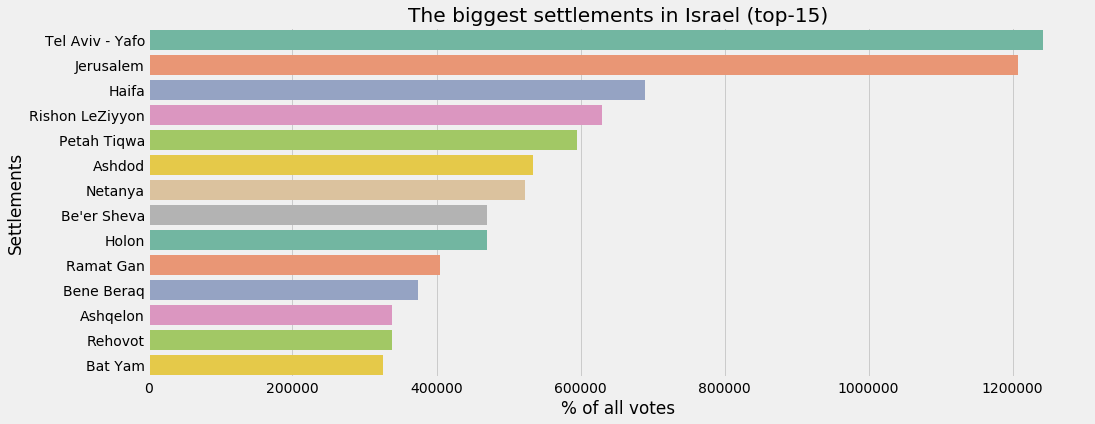

In [8]:
# Plot "The biggest Israeli settlements"
settl_top = c21_viz.sum(axis=1).reset_index()
settl_top.columns = ['settlement', 'values']
settl_top = settl_top.sort_values('values', ascending=False)
settl_top['percent'] = round(settl_top['values'] / settl_top['values'].sum() * 100, 2)
settl_top['settlement'] = c21_viz['settlement']
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
sns.barplot(y='settlement', x='values', data=settl_top.head(15), palette=sns.color_palette("Set2", 15))
plt.title('The biggest settlements in Israel (top-15)')
plt.ylabel('Settlements')
plt.xlabel('% of all votes')
plt.show()

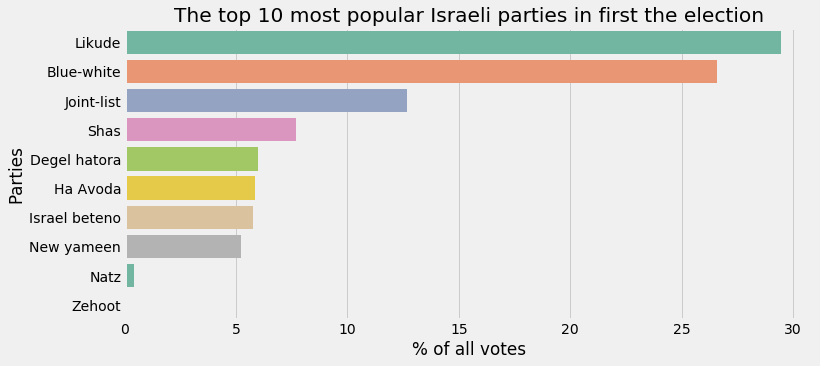

In [9]:
# Top-10 parties
party_top = c21_viz.drop(['סמל ועדה','סמל ישוב','בזב','מצביעים','פסולים','כשרים'], axis=1)
party_top = party_top.sum().reset_index()
party_top.columns = ['party', 'values']
party_top = party_top.sort_values('values', ascending=False)
party_top['percent'] = round(party_top['values']/party_top['values'].sum()*100, 2)
# Plot "The most popular israili parties in 2015"
fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(111)
sns.barplot(y='party', x='percent', data=party_top.head(10), palette=sns.color_palette("Set2"))
plt.title('The top 10 most popular Israeli parties in first the election')
plt.ylabel('Parties')
plt.xlabel('% of all votes')
plt.show()

Since after the 8th party, the number of votes per party gets lower and lower we assume these small parties do not affect our analysis and we'll be removing them before starting to run our models.

## 2.2. Correlation Matrix <a class="anchor" id="col-matrix"></a>

First get all features in one dataframe, 
we already have 'features' which has all features from bycode, join it with ['סמל ישוב', 'מצביעים', 'פסולים', 'כשרים'] from c21 
remove unwanted features like name and year 
then build correlation matrix and heatmap.

In [11]:
''' DATA '''
c21_viz = c21_viz[['סמל ישוב', 'מצביעים', 'פסולים', 'כשרים']]
c21_viz = pd.merge(c21_viz, features,  how='left', left_on=['סמל ישוב'], right_on = ['סמל ישוב'])
c21_viz = c21_viz.drop(['סמל ישוב','מרחב משטרה'],axis=1)
c21_viz = translate_bycode(c21_viz)
c21_viz = to_int(c21_viz)

In [12]:
''' Correlation Matrix '''
fig = px.scatter_matrix(c21_viz, color="Voters", title="Scatter matrix of features",width=950,
    height=1000, dimensions=['Voters', 'Disqualified', 'Qualified','Natural area', 'District', 'Religion', 
                            'Municipal status'])
fig.show()

The only visible colleration here is the number of Disqualified and Qualified votes getting higher with number of votes, which is an expected colleration.

The religion feature shows higher votes and qualified votes in religioin 1 = jews but that is not a feature since most israel's population are jews... 
Same with מעמד מוניציפילי we can clearly see higher voting rates in status = 0 which is עירייה but we cant infer a correlation since it also has higher population.

## 2.3. Correlation Between Features <a class="anchor" id="feat-matrix"></a>

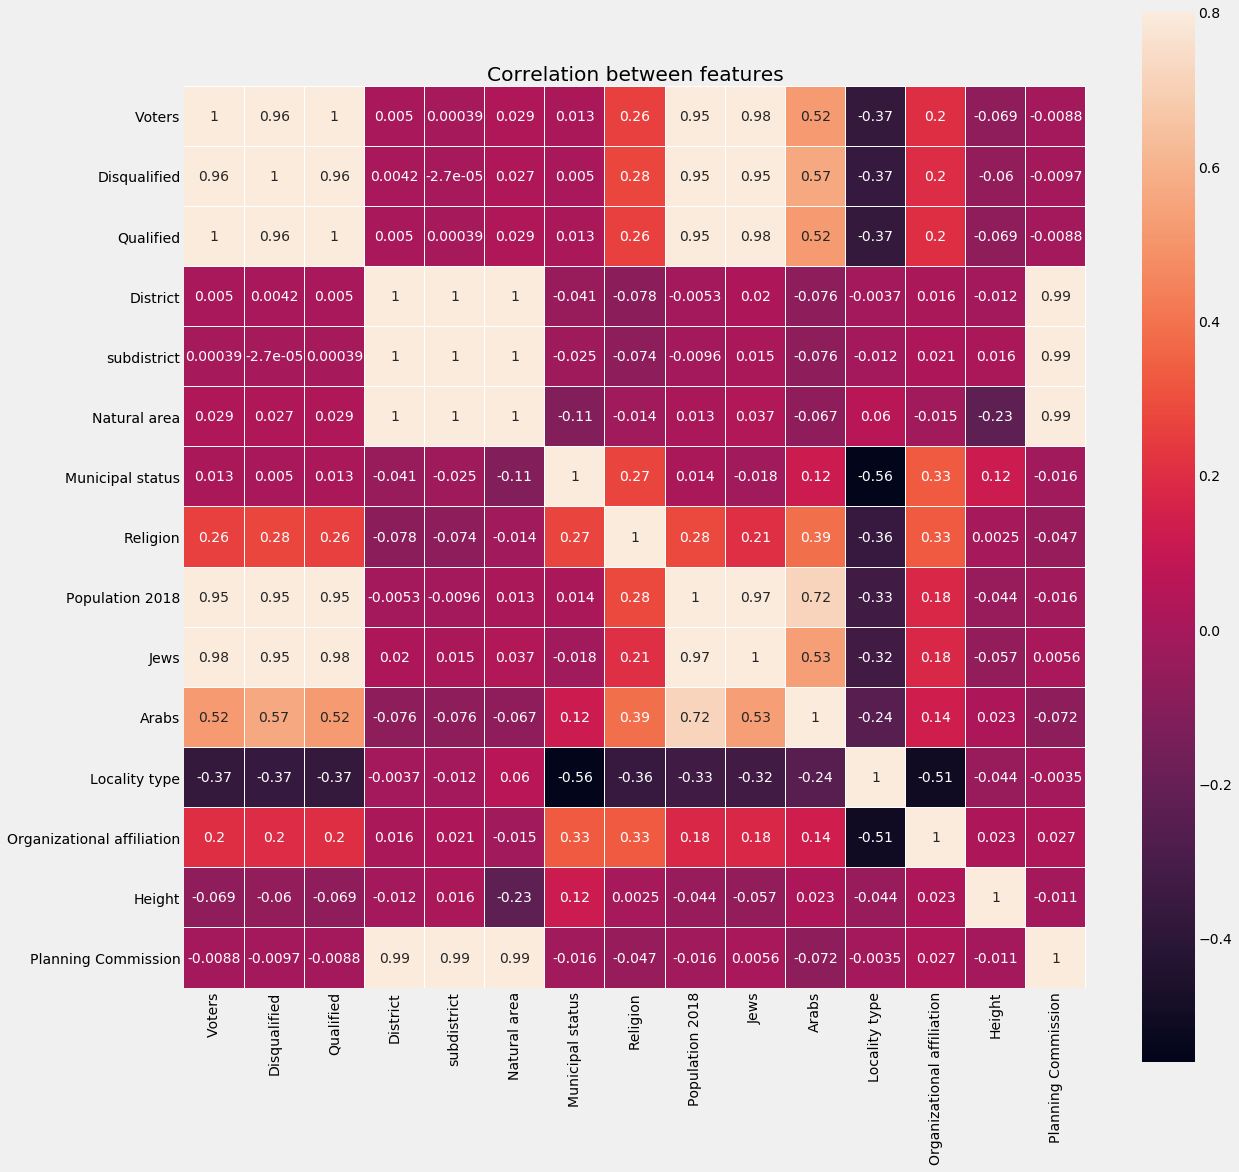

In [13]:
''' Correlation Heatmap '''

corr = c21_viz.corr()
plt.figure(figsize=(18, 18))

sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True, annot=True, linecolor="white")
plt.title('Correlation between features');
plt.show()

In [14]:
# delete variables 
del c21_viz
del corr

<hr>

# 3. Clustering - Demographic analysis <a class="anchor" id="clustering-header"></a>

The research question we'll be trying to answer in this section is: <b> Is Israel's district distribution correlated to which parties each settlement votes for ?</b> in other words can we expect Nazareth's votes to be to certian parties just for the fact that it's in Israel's Northern District?

To do that we'll fit the data of pure votes using two clustering methods, after we have K clusters we'll view their districts and infer if we indeed found a correlation or not. 


## Get relevant data

We'll be working on data from first elections, so we'll copy that df and process the votes by:

- Remove all parties with less that 1,000 votes.
- Removing all none party columns.
- Normalize the vote count using PCA from sklearn.
- Converge the votes to a tuple with x and y values - to be able to plot the data.

In [15]:
#Get first election's data
clus_c21 = c21.copy()

# Drop parties with small number of voters. 
relevant_parties = drop_parties(clus_c21, 1000)
# Translate settlment name hebrew -> english
relevant_parties = get_english_settlements(relevant_parties)
clus_data = relevant_parties.set_index('settlement')
# Remove none party columns
clus_data = clus_data.drop(['כשרים', 'פסולים', 'מצביעים', 'בזב', 'סמל ישוב', 'סמל ועדה'], axis=1)
clus_data = to_int(clus_data)

# Normalize the votes to smaller numbers [0,1]
relative_votes = clus_data.div(clus_data.sum(axis=1), axis=0)

'''    for i,r in df_original.iterrows():
        for c in columns:
            x = r[c]/r['valid votes']
            df.at[i , c]=x'''
#Converge them into (x,y) dots to help plotting
xy = sklearnPCA(n_components=2).fit_transform(relative_votes)
#To be able to plot 3D scatterplot converge to (x,y,z) tuples aswell
xyz = sklearnPCA(n_components=3).fit_transform(relative_votes)

#Save in dataframes
threeD = pd.DataFrame(xyz)
pca_df = pd.DataFrame(xy)

In [16]:
# save locations and sizes alone, needed for a graph after the clustering. 
locations = relevant_parties[['settlement', 'סמל ישוב']]
sizes = relevant_parties[['סמל ישוב','מצביעים']]
sizes = sizes.rename(columns={'מצביעים': 'size'})

#Add to (x,y) df to help us later with viz
pca_df['locations'] = locations['settlement']
pca_df['sizes'] = sizes['size']

In [17]:
relative_votes = translate_top_parties(relative_votes)
relative_votes.head(2)

Ha Avoda  Degel hatora  Joint-list  Zehoot  New yameen  \
settlement                                                             
Abu Juway'ad  0.022184      0.000000    0.945392     0.0    0.000000   
Abu Ghosh     0.028090      0.001498    0.807865     0.0    0.001873   

              Israel beteno    Likude    N      Natz  Blue-white  \
settlement                                                         
Abu Juway'ad       0.001706  0.006826  0.0  0.000000    0.013652   
Abu Ghosh          0.001873  0.104869  0.0  0.001124    0.046067   

              Internet pirates      Kets      Shas  
settlement                                          
Abu Juway'ad          0.003413  0.003413  0.003413  
Abu Ghosh             0.000000  0.001498  0.005243

### Data

The data we've built for the clustering method is in 'relative_votes' df which contains normalized votes for the following parties:
- 'אמת' - Ha Avoda 
- 'ג' - Degel hatora 
- 'ודעם' - Joint-lis 
- 'ז' - Zehoot 
- 'טב' - New yameen 
- 'ל' - Israel beteno 
- 'מחל' - Likude 
- 'נ' - N (newYameen) 
- 'נץ' - Nets 
- 'פה' - Blue-white 
- 'ףז' - Internet pirates 
- 'קץ' - Kets 
- 'שס' - Shas

in addition 'pca_df' has a tuple (x,y) where x is saved under '0' and y under '1' that represents the % of votes each settlement had for each party, in addition this dataframe has two more columns, one for the settlement's name and the other for the total number of voters in it. 

Atfer the clustering is done we'll need each settlement's name and number of voters to build a few visualizations, so we add them to our vote tuples.

##### Plot data for now 

In [18]:
# Plot the data on a graph to see the nodes before and after clustering. 
fig =  plotly.subplots.make_subplots(rows=1, cols=2, horizontal_spacing=0.03, specs=[[{"type": "xy"},{"type": "scatter3d"}]])
fig.add_trace(
    go.Scatter( x=pca_df[0], y=pca_df[1],marker_symbol='hexagon2', mode="markers+text", 
               marker=dict(size=12,color='rgba(135, 206, 250, 0.7)', line=dict(width=1, color='DarkSlateGrey'))),
    row=1, col=1)
fig.add_trace(
    go.Scatter3d(x=threeD[0], y=threeD[1], z=threeD[2], 
                 mode="markers",marker_symbol='circle-open', marker=dict(size=7)),
    row=1, col=2)
fig.update_xaxes(title_text="x", row=1, col=1)
fig.update_yaxes(title_text="y", row=1, col=1)
fig.update_layout(height=600, width=1000,
                  title_text="Plotting data after lowering the it's dimention, once in 2D the other 3D", showlegend=False)
fig.show()

Looking at the scatter plots above we can already think of how the data will be clustered, we'll draw scatter plots after the clustering is done to see if we get what we expected.

## 3.1. Kmeans <a class="anchor" id="kmeans"></a>

#### Choose K

Now the data is ready, last thing before runnning the cluster algorithm is figure out the number of needed clusters:
To do that we use the Elbow method, where the distance is calculated by the eulidean distance.

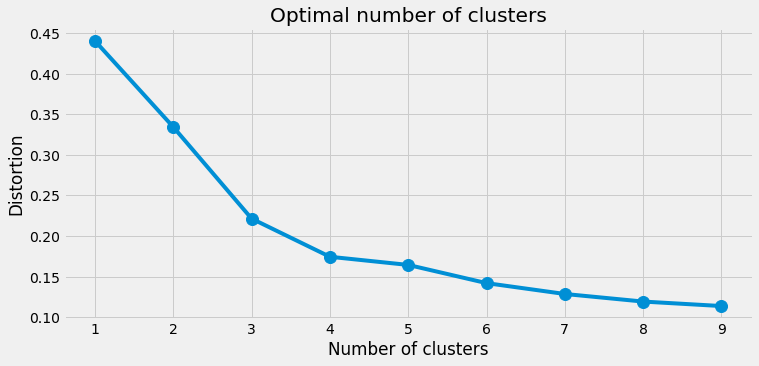

In [19]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=10000).fit(relative_votes)
    #kmeanModel.fit(only_parties)
    distortions.append(sum(np.min(cdist(relative_votes, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / relative_votes.shape[0])
plt.figure(figsize=(11, 5))
plt.plot(K, distortions, 'o-', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Optimal number of clusters')
plt.show()

##### K = 4
since after k=4 the distortion started decreasing much slower than before. 

## Fit the data

In [20]:
K=4; 
kmeanModel = KMeans(n_clusters=K, max_iter=10000).fit(relative_votes)

print("The parties in each cluster: ")
kmeans_cluster_info = [1]*K
cluster=[1]*K
for k in range(0,K):
    cluster[k]=tuple(zip(kmeanModel.cluster_centers_[k],relative_votes.columns))
    cluster[k]=sorted(cluster[k],reverse=True)
    info = 'Cluster' + str(k+1) + ':'
    print ('Cluster '+str(k+1)+':', end=' ')
    for i in range(0,4):
        info = info + cluster[k][i][1] + "-" + str(round(100*cluster[k][i][0])/100) + ', '
        print(cluster[k][i][1]+" - "+str(round(100*cluster[k][i][0])/100), end=', ')
    kmeans_cluster_info[k] = info
    print()



The parties in each cluster: 
Cluster 1: Blue-white - 0.58, Ha Avoda - 0.19, Likude - 0.15, New yameen - 0.03, 
Cluster 2: Likude - 0.5, Blue-white - 0.18, Shas - 0.11, New yameen - 0.06, 
Cluster 3: Joint-list - 0.92, Blue-white - 0.03, Ha Avoda - 0.03, Likude - 0.01, 
Cluster 4: New yameen - 0.55, Likude - 0.26, Blue-white - 0.06, Degel hatora - 0.05, 


## Visualize the Results
 
First we'll create a df 'kmeans_graph' which includes all needed data to build relevant charts:
- '0' and '1' - the normalized values of each tuple in the main elections table.
- 'label' - a number between 0 and 5 which represents to which cluster this tuple belongs. 
- 'locations' - the name of the tuple's settlement. 
- 'size' - the number of voters in that settlement. 
- 'dis' - the district of the settlement, one of אזור יהודה ושומרון, מחוז הדרום, מחוז תל אביב, מחוז המרכז, מחוז חיפה, מחוז הצפון, מחוז ירושלים


In [21]:
# Get districts and change them from numbers to names 
districts = features[['סמל ישוב', 'מחוז' ]]
districts = districts.rename(columns={'מחוז': 'district'}) 
districts.district = districts.district.astype(str)
districts = name_districts(districts)

#Get pca_df and add new features.
kmans_graph = pca_df
#Add predected labels
kmans_graph['label'] = kmeanModel.predict(relative_votes)
#Add district
kmans_graph['dis'] = districts['district']
print('Example')
kmans_graph.head(1)

Example


0         1     locations  sizes  label         dis
0  0.863105 -0.384299  Abu Juway'ad    595      2  מחוז הדרום

### Scatter Chart of the clusters with districts

In [22]:
'''
Given a df build a scatter plot to view clusters
t - is the cluster method to add it in title (kmeans or GMM)
clusterinfo - is a list of clusters information to add it to legend
'''
def scatter_clusters(df, t, clusterinfo):
    traces = []
    i=0
    for label in sorted(df.label.unique()):
        traces.append(
            go.Scatter3d(x=df[df.label == label][0], y=df[df.label == label][1], z=df[df.label == label]['dis'], 
                         text=df[df.label == label]['locations'], mode='markers',
                hoverinfo='text', name = clusterinfo[i], opacity = 0.8 )),
        i=i+1
    layout = go.Layout(
            width=900, height=700, template='simple_white', title= t + ' Resulting Clusters',
            hovermode='closest', xaxis=dict( title = 'x'), yaxis=dict(title = 'y'), legend_orientation="h")
    return go.Figure(data=traces, layout=layout)

<b> Explanation: </b> the x axis and y axis of the scatter plot below represent the settlements after we lowered their dimention to 2D, the color represents the cluster number from fitting the data using kmeans method and finally the <b> z axis </b> represents the district of the settlement (this feature <b>was not</b> part of the data we're presenting it this way to see if there's a correlation between votes and districts) 

In [24]:
scatter_clusters(kmans_graph, 'Kmeans', kmeans_cluster_info)

### Scatter Chart with relevance to number of voters in a settlement

In the scatter plot below is similar to the one we did before fitting the data using kmeans, in addition to that here the dot's size reffers to number of voters in that settlement and it's color to the cluster we predict it to be in. 

In [25]:
'''
Given a df build a scatter plot with size proportional to number of voters
t - is the cluster method to add it in title (kmeans or GMM)
clusterinfo - is a list of clusters information to add it to legend
'''
def scatter_with_size(df, t, clusterinfo):
    traces = []
    i=0
    for label in sorted(df.label.unique()):
        traces.append(go.Scatter(
                x=df[df.label == label][0], y=df[df.label == label][1], text=df[df.label == label]['locations'],
                mode='markers', hoverinfo='text', name = clusterinfo[i],
                marker=dict( size=[np.sqrt(a)/5 for a in (df[df.label == label]['sizes'])], )))
        i=i+1

    layout = go.Layout(
            width=970,
            height=750,
            template='seaborn',
            title= t + ' Resulting Clusters with Number of Votes as Size',
            hovermode='closest',
            xaxis=dict(
                title = 'x', autorange=True, showgrid=True, zeroline=False,
                showline=False, ticks='', showticklabels=True),
            yaxis=dict( title = 'y', autorange=True, showgrid=True, zeroline=False,
                showline=False, ticks='', showticklabels=True), 
            legend_orientation="h")
    return go.Figure(data=traces, layout=layout)

In [26]:
fig = scatter_with_size(kmans_graph, 'Kmeans', kmeans_cluster_info)
py.iplot(fig)

### Display clusters on Israel map

To do that we added a new csv from an election 4 years ago which has Latitude and Longitude of 98% of the settlements we have we read that cvs and save it in 'bycode_new'. 
Now we build a new dataframe 'map_df' which contains:
- 'label' - a number between 0 and 5 which says to which clusters this settlement belongs. 
- 'sizes' - number of voters in the settlement. 
- 'locations' - settlement name. 
- 'lat' and 'long' - the coordinates used to map the settlements on the map.

In [28]:
# Get new bycode and keep only relevant data -> settlementCode, X_GEO, Y_GEO
bycode_new = pd.read_csv(r'data/coord.csv', encoding='utf-8')
coord = bycode_new[['SettlementCode', 'X_GEO', 'Y_GEO']].copy()

# Join our bycode with the coordinates 
joined = pd.merge(bycode, coord,  how='left', left_on=['סמל יישוב'], right_on = ['SettlementCode'])
joined = pd.merge(joined, sizes, how='right', left_on=['סמל יישוב'], right_on=['סמל ישוב'],)
# Remove nulls
joined = joined[joined['X_GEO'].notna()]
joined = joined[joined['Y_GEO'].notna()]

In [29]:
map_df = kmans_graph.copy()

map_df['lat'] = joined.Y_GEO
map_df['lng'] = joined.X_GEO
map_df['locations'] = joined['שם יישוב באנגלית']
'''
there are 53 settlements that dont have name in english, and displaying name in hebrew does not work 
(missing UTF-8) so we replaced NaNs in location with Undefined.
'''
map_df['locations'] = map_df['locations'].replace(np.nan, 'Undefined', regex=True)
map_df['sizes'] = joined['size']
map_df = map_df[map_df['lat'].notna()]
map_df = map_df[map_df['lng'].notna()]
map_df = map_df.drop([0,1], axis=1)

print('An example :')
map_df.head(1)

An example :


locations  sizes  label         dis       lat        lng
0    Shahar  387.0      2  מחוז הדרום  31.61962  34.725148

In [68]:
# Create Legend for the map
'''
NOTE: 
The legend includes % of voted to partied which was hardcoded into the map since making it manual didnt work...
But with it it's easier to understand the clusters. 
The parties in each cluster: 
'''
template = """
{% macro html(this, kwargs) %}
<!doctype html> <html lang="en"> <head> <meta charset="utf-8"> </head>
<body>
<div id='maplegend' style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
<div style='margin-bottom: 5px; font-weight: bold;'>Legend</div> 
<div> <ul style='padding: 0; float: left; list-style: none;'>
    <li><span style='background:#0173b2;opacity:0.7; float: left; height: 16px; width: 30px; margin-right: 5px;'>
    </span>Cluster1: Blue-white-0.58, HaAvoda-0.19, Likude-0.15, Newyameen-0.03</li>
    <li><span style='background:#cc78bc;opacity:0.7; float: left; height: 16px; width: 30px; margin-right: 5px;'>
    </span>Cluster2: Likude-0.5, Blue-white-0.18, Shas-0.11, Newyameen-0.06</li>
    <li><span style='background:#029e73;opacity:0.7; float: left; height: 16px; width: 30px; margin-right: 5px;'>
    </span>Cluster3: Joint-list-0.92, Blue-white-0.03, Ha Avoda-0.03, Likude-0.01</li>
    <li><span style='background:#d55e00;opacity:0.7; float: left; height: 16px; width: 30px; margin-right: 5px;'>
    </span>Cluster4: Newyameen-0.55, Likude-0.26, Blue-white-0.06, DegelHatora-0.05</li>

  </ul> </div> </div> </body> </html> {% endmacro %}"""

In [69]:
macro = MacroElement()
macro._template = Template(template)
# Create map
m = folium.Map(location=[32.13,34.8],zoom_start=9, tiles="CartoDB Positron")
# Get color pallet

colors = ['#0173b2', '#cc78bc', '#029e73', '#d55e00']

# Add circles for settlements
for row in map_df.iterrows():
    folium.Circle(
        location= (row[1].lat, row[1].lng),
        radius = 0.04*row[1].sizes,
        popup = '<b>' + str(row[1].locations),
        color = colors[row[1].label],
        fill = True,
        fill_color = colors[row[1].label],
    ).add_to(m)
#Add legend
m.get_root().add_child(macro)
#Show map
m

## 3.2. GMM <a class="anchor" id="gmm"></a>

The needed data for GMM clustering is the same data we prepared in the previous part which is in 'relative_votes'
So, now we need to find the best number of clusters to use, we'll do that using BIC score ( found it online 
<a href="https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4"> here</a> ) where the choosen number of clusters is the one that after it the score becomes almost constant.

In [32]:
evluate_bic = {}
n_components_range = range(2, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
# checking what are the best parameters for GMM
for cv_type in cv_types:
    bic = []
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,covariance_type=cv_type)
        gmm.fit(relative_votes)
        bic.append(gmm.bic(relative_votes))
        labels = gmm.predict(relative_votes)
    evluate_bic[cv_type] = bic
    
# Plot the results on a bar chart
n_components_range = [2,3,4,5,6,7,8,9]

fig = go.Figure()

# ploting metrics
for key in evluate_bic:
    fig.add_trace(go.Bar( x = n_components_range, y = evluate_bic[key], name=key ))
# layout
layout = go.Layout(barmode='group', template='seaborn', title= 'Gradient of BIC Scores',
                   xaxis=dict(title = 'Number of clusters'), yaxis=dict( title = 'Score', range=[0, -120000]))
fig.update_layout(layout)
fig.show()

In [33]:
#The choosen number of clusters is 6
K = 5

## Fit the data

In [34]:
gmmModel = GaussianMixture(n_components=K).fit(relative_votes)
labels = gmmModel.predict(relative_votes)

## Visualize the Results
 
First we'll create a df 'gmm_graph' which includes all needed data to build relevant charts:
- '0' and '1' - the normalized values of each tuple in the main elections table.
- 'label' - a number between 0 and 5 which represents to which cluster this tuple belongs. 
- 'locations' - the name of the tuple's settlement. 
- 'size' - the number of voters in that settlement. 
- 'dis' - the district of the settlement, one of אזור יהודה ושומרון, מחוז הדרום, מחוז תל אביב, מחוז המרכז, מחוז חיפה, מחוז הצפון, מחוז ירושלים

In [35]:
gmm_graph = pd.DataFrame(xy)
gmm_graph['label'] = labels
gmm_graph['locations'] = locations['settlement']
gmm_graph['sizes'] = sizes['size']
gmm_graph['dis'] = districts['district']

### Scatter Chart of the clusters with districts

same explanation as the one in kmeans.

In [37]:
gmm_info = [1]*K
for i in range(0,K):
    gmm_info[i] = 'Cluster ' + str(i+1)
scatter_clusters(gmm_graph, 'GMM', gmm_info)


### Scatter Chart with relevance to number of voters in a settlement

Same scatter plot as in kmeans.

In [38]:
fig = scatter_with_size(gmm_graph, 'GMM', gmm_info)
py.iplot(fig)

## Conclustions

We can see a certain change in some districts, nothing too major but for example מחוז תל אביב has votes to both right and left parties, but not too right (doesnt vote to cluster 3 which is mainly ג and שס). and in אזור יהודה we can clearly see the lack of voting to left parties, other districts are filled with both jewish settlements and arab settlements which even outs the clusters in it, with certain change depending on number of arab vs. jews settlements in it. 

All in all, other than changes between mainly jews district and mixed districts both both clustering methods didn't find any deeper correlation. 


## Compare the clustering methods

We can compare the resulted clusters using measures provided by <a href='https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient'>sklearn</a>:
1. Silhouette Coefficient - score between [-1,1] where higher score means the clusters are better defined.
2. Calinski-Harabasz Index - like before, a higher score means better defined clusters which means densed and well separated.
3. Davies-Bouldin Index - unlike the first two here a lower score (lowest score = 0) relates to better separation between the clusters, this index signifies the average ‘similarity’(distance) between clusters and it's size.


In [39]:
kmeanslabels = kmeanModel.labels_
gmmlabels = gmmModel.predict(relative_votes)

#the score is -1 for incorrect clustering and +1 for highly dense clustering, around 0 indicate overlapping clusters
print("kmeans silhouette", round(metrics.silhouette_score(xy, kmeanslabels, metric='euclidean'),5))
print("gmm silhouette", round(metrics.silhouette_score(xy, gmmlabels, metric='euclidean'),5))
# higher score -> model with better defined clusters
print("\nkmeans calinski harabasz", round(metrics.calinski_harabasz_score(xy, kmeanslabels),5))
print("gmm calinski harabasz", round(metrics.calinski_harabasz_score(xy, gmmlabels),5))
# Values closer to zero indicate a better partition.
print("\nkmeans davies bouldin", round(metrics.davies_bouldin_score(xy, kmeanslabels),5))
print("gmm davies bouldin", round(metrics.davies_bouldin_score(xy, gmmlabels),5))

kmeans silhouette 0.50621
gmm silhouette 0.37593

kmeans calinski harabasz 4272.34109
gmm calinski harabasz 2310.56028

kmeans davies bouldin 0.84623
gmm davies bouldin 1.27306


In all of the measures it looks like kmeans clusters are "better" than gmms clusters, but that can only be the cause of gmms weird shaped clusters and not because it did a worst job.

<hr>

# 4. Random Forest - Predict number of valid votes <a class="anchor" id="forest-header"></a>

The research question in this section is <b> What is the number of eligible votes in the last elections in Haifa, Ayelet Hashachar, Eilat, Sakhnin and Katzrin? </b>
To answer this question out model was trained on settlement features and the number of eligible votes in the previous elections and the result would be the number of eligible votes in the "current" elections (once for 2nd elections and once for 3rd).

The used settlement features are detailed below, after the training is done we checked which features are the most important ones hoping they'll give us an insight or a colleration. 

## Get relevant data

Copy the df of the 3 elections and the bycode table.
rearrange the data to train, test and eval. 

In [40]:
rf_c21 = c21.copy()
rf_c22 = c22.copy()
rf_c23 = c23.copy()
rf_bycode = bycode.copy()

# Use the method we created earlier to fill NaN values with mean or zeros 
rf_bycode = process_bycode(rf_bycode)

rows_to_predict = ['חיפה', 'איילת השחר', 'אילת', "סחנין", 'קצרין']

In [41]:
# ID's of settlements for predictions
keep = [77, 2600, 4000, 7500, 4100]
# Features to drop
to_drop = ['סמל ישוב', 'שם יישוב', 'שם יישוב באנגלית',
           'valid_third', 'מעמד מונציפאלי']

first_ele = rf_c21[['סמל ישוב', 'כשרים']]
first_ele = first_ele.rename(columns={'כשרים': 'valid_first'})
second_ele = rf_c22[['סמל ישוב', 'כשרים']]
second_ele = second_ele.rename(columns={'כשרים': 'valid_second'})
third_ele = rf_c23[['סמל ישוב', 'כשרים']]
third_ele = third_ele.rename(columns={'כשרים': 'valid_third'})

valid_votes = pd.merge(first_ele, second_ele, on = ['סמל ישוב'])
valid_votes = pd.merge(valid_votes, third_ele, on = ['סמל ישוב'])
rf_bycode = rf_bycode.rename(columns={'סמל יישוב': 'סמל ישוב'})

all_data = pd.merge(valid_votes, rf_bycode, on = ['סמל ישוב'])
all_data = all_data.fillna(0)

In [42]:
''' Test Data '''
test = all_data[all_data['סמל ישוב'].isin(keep)]
ytest = test['valid_third']
xtest = test.drop(to_drop, axis=1)
xtest = xtest.drop(['valid_first'], axis=1)
xtest = xtest.rename(columns={'valid_second': 'valid_prev'})

''' Train Data '''
train1 = all_data[~all_data['סמל ישוב'].isin(keep)]
ytrain1 = train1[['valid_third']]
ytrain1 = ytrain1.rename(columns={'valid_third': 'actual'})
xtrain1 = train1.drop(to_drop, axis=1)
xtrain1 = xtrain1.drop(['valid_first'], axis=1)
xtrain1 = xtrain1.rename(columns={'valid_second': 'valid_prev'})

train2 = all_data.copy()
ytrain2 = train2[['valid_second']]
ytrain2 = ytrain2.rename(columns={'valid_second': 'actual'})
xtrain2 = train2.drop(to_drop, axis=1)
xtrain2 = xtrain2.drop(['valid_second'], axis=1)
xtrain2 = xtrain2.rename(columns={'valid_first': 'valid_prev'})

ytrain = pd.concat([ytrain1, ytrain2])
ytrain = ytrain['actual']
xtrain = pd.concat([xtrain1, xtrain2])

##### Final data

After the cleaning and trimming the dataframes we decided to keep the following features:

- valid_prev - number of valid votes in the previous elections
- נפה
- אזור טבעי
- מחוז
- מזה: יהודים
- יהודים ואחרים
- סך הכל אוכלוסייה 2018
- דת יישוב
- השתייכות ארגונית
- גובה
- צורת יישוב שוטפת
- ערבים
- מרחב משטרה
- ועדת תכנון

The test data are <b> xtest </b> and <b> ytest </b> where, xtest contains the features above ('valid_prev' features contrains the number of legal votes from the 2nd elections) and ytest has the number of legal votes, both for the following settlements from the 3rd election.
1. חיפה
2. קצרין
3. סח'נין
4. אילת
5. איילת השחר

The train data are <b> xtrain </b> and <b> ytrain </b> can be devided into two parts: 
1. 1212 tuples (all settlements) where 'valid_prev' is number of valid votes in the first elections, and ytrain has the number of valid votes in the 2nd elections. 
2. 1207 tuples (settlements without the 5 that are in the test set) where where 'valid_prev' is number of valid votes in the 2nd elections, and ytrain has the number of valid votes in the 3nd elections. 

## Create and Train the Model

To ensure finding the best model we create a grid search object and fit the data to all possible combinations.

In [43]:
param_grid = {
    'criterion':['mse'],
    'n_estimators': [150, 180, 200, 220],  # The number of trees in the forest.
    'max_depth': [None, 40, 60, 80],  # The maximum depth of the tree.
    'max_features': ['sqrt',4,5],  # he number of features to consider when looking for the best split
    'min_samples_split': [None, 3, 4],  # The minimum number of samples required to split an internal node
    'bootstrap': [True]  # Whether bootstrap samples are used when building trees.
}

# Create a grid search object
gsRFC = GridSearchCV(RandomForestRegressor(), param_grid, n_jobs=-1, cv=5)

# Fit
gsRFC.fit(xtrain, ytrain)
gsRFC.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 80,
 'max_features': 5,
 'min_samples_split': 3,
 'n_estimators': 220}

## Run Prediction and Calculate MSE

Given the best model run predictions and calculate the MSE of the model.

In [44]:
# run prediction
new_best_model = gsRFC.best_estimator_
ypred = new_best_model.predict(xtest)

# calulate MSE
mse = mean_squared_error(ytest, ypred)
print('The model\'s MSE is ' + str(round(mse, 2)))

The model's MSE is 43167503.55


## Visualize the Results

First we'll create a new dataframe 'rf_graph' with the following columns:
- Settlement.
- 'Test' - Actual number of valid votes in each settlement.
- 'Pred' - Predected number of valid votes in each settlement.
- 'MSE' - the mean squared error for that settlement which is (predicted - actual)^2
- 'logMSE' - log(MSE) since the numbers are huge and hard to vizualilze them.

In [45]:
# Create and get relevant data only
rf_graph = rf_c23[rf_c23['שם ישוב'].isin(rows_to_predict)].copy()
rf_graph = rf_graph.drop(['סמל ועדה', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים',
       'אמת', 'ג', 'ודעם', 'ז', 'זך', 'זץ', 'טב', 'י', 'יז', 'ינ', 'יף', 'יק',
       'יר', 'כ', 'כן', 'ל', 'מחל', 'נ', 'נז', 'ני', 'נץ', 'נק', 'פה', 'ףז',
       'ץ', 'ק', 'קי', 'קך', 'קץ', 'שס', 'Unnamed: 37'], axis=1)
rf_graph['Pred'] = np.round(ypred)
rf_graph = rf_graph.rename(columns={'שם ישוב': 'Settlement', 'כשרים':'Test'})

rf_graph['MSE'] = (rf_graph['Pred']-rf_graph['Test'])**2
rf_graph['logMSE'] = np.round(np.log(rf_graph['MSE']), 2)

#Now we'll display the results in a table; actual number of legal votes, predicted number with MSE and log(MSE)
fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Settlement</b>', '<b>Actual</b>', '<b>Predicted</b>', '<b>MSE</b>' ,'<b>log(MSE)</b>'],
                line_color='darkslategray', fill_color='rgb(158,202,225)',
                font=dict(size=13), align='center'),
    cells=dict(values=[rf_graph['Settlement'], rf_graph['Test'], rf_graph['Pred'], rf_graph['MSE'] ,rf_graph['logMSE']],
               line_color='darkslategray', fill_color = ['rgb(222,252,229)','white'],
               align = 'center', font = dict(color = 'darkslategray', size = 13) ))
])
fig.update_layout(width=800, height=315, title='Actual number of legal votes vs. predicted number of legal votes with log(MSE)')
fig.show()

Here we display the results in two charts:

1. bar chart with both test data which is the actual number of legal votes and prediced data. 
2. bar chart of log(MSE) so we can compare the mean square error - here we used log(MSE) and not MSE since the MSE gave us large values which makes it hard ti chart it without losing the smaller ones, log(MSE) represents the diffrences between the values as they are simply with smaller numbers. 

In [46]:
#Create the charts
test_trace = go.Bar(name='Test', x=rf_graph['Settlement'], y=rf_graph['Test'], text=rf_graph['Test'], textposition='auto', 
           marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6)
pred_trace = go.Bar(name='Pred', x=rf_graph['Settlement'], y=rf_graph['Pred'], text=rf_graph['Pred'], textposition='auto',
           marker_color='rgb(180,300,200)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
error_trace = go.Bar(name='Error', x=rf_graph['Settlement'], y=rf_graph['logMSE'], text=rf_graph['logMSE'], textposition='auto',
           marker_color='rgb(224,127,127)', marker_line_color='rgb(255,255,255)',marker_line_width=1, opacity=0.6)

rf_fig = plotly.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
rf_fig.append_trace(test_trace, 1,1)
rf_fig.append_trace(pred_trace, 1,1)
rf_fig.append_trace(error_trace, 2, 1)

# Update xaxis and yaxis properties
rf_fig.update_xaxes(title_text="Settlement", row=2, col=1)
rf_fig.update_yaxes(title_text="Votes", row=1, col=1)
rf_fig.update_yaxes(title_text="log(MSE)", row=2, col=1)

rf_fig['layout'].update(height=600, width=950, title={'text': "Final Results Comparison", 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'})
rf_fig.show()

In [47]:
#Delete used variables

del rf_c21
del rf_c22
del rf_c23
del rf_bycode
del rf_graph
del xtrain
del ytrain
del xtest
del ytest

<hr>

# 5. Adaboost - Predict number of voters<a class="anchor" id="adaboost-header"></a>

Our goal in this section is to <b>predict the number of voters for parties: Likud, the joint list and blue-white in the following settlements: Jerusalem, Bnei Brak, Sakhnin, Carmiel, and Dalit al-Carmel.</b>


## Get Relevant data

- Copy the df of the 3 elections and the bycode table.
- Cleanse the data and keep relevant parties only.
- Split into train and test datasets.
- Split by party.

In [48]:
ada_c21 = c21.copy()
ada_c22 = c22.copy()
ada_c23 = c23.copy()
ada_bycode = bycode.copy()

rows_to_predict = ['ירושלים', 'בני ברק', "סחנין", 'כרמיאל', 'דאלית אלכרמל']
row_to_test = ['ירושלים', 'בני ברק', "סח'נין", 'כרמיאל', 'דאלית אל-כרמל']
cols_to_drop = ['שם יישוב', 'סמל ישוב', 'שם יישוב באנגלית']

"""Data Cleansing"""
# fill NaN's and other
ada_bycode = process_bycode(ada_bycode)

#merge the first two elections together
frames = [ada_c21, ada_c22]
elections12 = pd.concat(frames, sort=False)
# keep only relevant parties
elections12 = elections12[['סמל ישוב', 'ודעם', 'מחל', 'פה']]
# join elections data with features (bycode table)
df4 = elections12.join(ada_bycode.set_index(['סמל יישוב'], verify_integrity=True),
               on=['סמל ישוב'], how='inner')
df4 = df4.fillna(0)

"""test data"""
x_test = df4[df4['שם יישוב'].isin(row_to_test)]
x_test = x_test.drop(cols_to_drop + ['ודעם', 'מחל', 'פה'] , axis=1)
x_test = x_test.drop_duplicates(subset=None, keep='first', inplace=False)
df4 = df4.drop(cols_to_drop, axis=1)
# df4 = df4.drop(labels.index, axis=0)

"""Train data"""
X = df4.drop(['ודעם', 'מחל', 'פה'], axis=1)

"""get labels, fill NAN with 0, assuming city has 0 votes"""
y1 = df4['פה'].fillna(0)
y2 = df4['ודעם'].fillna(0)
y3 = df4['מחל'].fillna(0)

"""get Test Label From 23st ellection unseen data"""
labels = ada_c23[ada_c23['שם ישוב'].isin(rows_to_predict)]
y_test1 = labels['פה']
y_test2 = labels['ודעם']
y_test3 = labels['מחל']

#### The data

Since we're building 3 independent models we're going to need 3 of each xtrain, ytrain, xtest, ytest

<b> xtrain </b> 

Before training each model we're going to run feature selection and select the best features and save them in x1_train, x2_train, x3_train based on the model itself. We're going to choose features from the dataframe we've created above called 'X' which includes the features from the first two election on all settlements, the features (we're explained what these features hold in previous sections):
- מחוז
- נפה 
- אזור טבעי
- מעמד מונציפאל
- דת יישוב
- סך הכל אוכלוסייה 2018
- מזה: יהודים
- ערבים
- צורת יישוב שוטפת
- השתייכות ארגונית
- גובה
- ועדת תכנון
- מרחב משטרה

<b> ytrain </b> 

The target train are saved in y1, y2, y3 where y1 is number of votes for Blue-white party in first 2 elections, y2 for the Joint list party and y3 for Likude.

<b> xtest </b> 

The x test data includes the same features we listed above, for the following settlements :ירושלים ,בני ברק ,סחנין  כרמיאל, דאלית אלכרמל Like before we keep relevant features after feature selection and save them in x1_train, x2_train, x3_train each for a different party.

<b> ytest </b> 

The target in test is number of votes in the 3rd election for the settlements listed in xtest, here too we have 3: y_test1, y_test2 and y_test3 each for a different party. 


## Create and Train the Models

To ensure getting the best results we use a param grid and keep the best model.

In [49]:
# Create gridsearch
ada_paramgrid = {'n_estimators':[50,100,150,200,250], 
                 'learning_rate':[0.001, 0.01, 0.1, 1],
                 'random_state': [1]}

def select_features(xtrain, ytrain, xtest, partyname):
    '''
    Given xtrain ytrain xtest this method selects important features based on 
    adaboost regressor and return the new xtrain and xtest
    '''
    sfm = SelectFromModel(AdaBoostRegressor())
    sfm.fit(xtrain, ytrain)
    # Printing the names of the most important features
    print('selected features in ' + partyname + ':')
    for ind in sfm.get_support(indices=True):
        print(xtrain.columns[ind])
    return sfm.transform(xtrain), sfm.transform(xtest)

"""Select features then fit the model, given correspoded labels"""
#Blue-white
X1, x1_test = select_features(X, y1, x_test, 'blue-white')
gs1 = GridSearchCV(AdaBoostRegressor(), param_grid = ada_paramgrid, cv=5, scoring = 'neg_mean_absolute_error', n_jobs= -1)
gs1.fit(X1, y1)
ada1 = gs1.best_estimator_

#joint-list
X2, x2_test = select_features(X, y2, x_test, 'joint-list')
gs2 = GridSearchCV(AdaBoostRegressor(), param_grid = ada_paramgrid, cv=5, scoring = 'neg_mean_absolute_error', n_jobs= -1)
gs2.fit(X2, y2)
ada2 = gs2.best_estimator_

#Likude
X3, x3_test = select_features(X, y3, x_test, 'likude')
gs3 = GridSearchCV(AdaBoostRegressor(), param_grid = ada_paramgrid, cv=5, scoring = 'neg_mean_absolute_error', n_jobs= -1)
gs3.fit(X3, y3)
ada3 = gs3.best_estimator_

selected features in blue-white:
סך הכל אוכלוסייה 2018
מזה: יהודים
selected features in joint-list:
ערבים
selected features in likude:
סך הכל אוכלוסייה 2018
מזה: יהודים


## Run Prediction and Calculate MSE

Given the 3 models, run predictions on each one and calculate it's MSE. 

In [50]:
"""Predict Data for Blue White"""
y_pred1 = ada1.predict(x1_test)
mse1 = mean_squared_error(y_test1, y_pred1)
print('MSE of Blue-White model ' + str(round(mse1,2)))

"""Predict Data for Joint List"""
y_pred2 = ada2.predict(x2_test)
mse2 = mean_squared_error(y_test2, y_pred2)
print('MSE of Joint-list model ' + str(round(mse2,2)))

"""Predict Data for Likude"""
y_pred3 = ada3.predict(x3_test)
mse3 = mean_squared_error(y_test3, y_pred3)
print('MSE of Likude model ' + str(round(mse3,2)))

MSE of Blue-White model 89002578.81
MSE of Joint-list model 3099590.5
MSE of Likude model 19735751.38


## Visualize the Results

In the first section we create a new dataframe 'ada_graph' which contains 
- Settlements 
- 'Joint list test' - Actual votes for joint list party. 
- 'Joint list pred' - Predicted votes for joint list party. 
- 'Blue white test' - Actual votes for Blue-white party. 
- 'Blue white pred' - Predicted votes for Blue-white party. 
- 'Likude test' - Actual votes for Likude party. 
- 'Likude pred' - Predicted votes for Likude party.

From the votes count for each of the parties we calculated the MSE per settlement, since the MSE results are high and presenting them in a graph doesn't show the diffrence clearly we added another column which is log(MSE) which is the column used in the graph below since it keeps the difference between mse's but with much smaller numbers. THE MSE and log(MSE) and under the following columns in ada_graph:
- 'BW_mse' - mse for Blue-white party.
- 'BW_logmse' - log(mse) for Blue-white party.
- 'JS_mse' - mse for Joint-list party.
- 'JS_logmse' - log(mse) for Joint-list party.
- 'L_mse' - mse for Likude party.
- 'L_logmse' - log(mse) for Likude party.

After we have the data ready we'll build charts to represent it and also print it in a table.


In [51]:
ada_graph = labels.drop(['סמל ועדה', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים',
       'אמת', 'ג', 'ז', 'זך', 'זץ', 'טב', 'י', 'יז', 'ינ', 'יף', 'יק',
       'יר', 'כ', 'כן', 'ל', 'נ', 'נז', 'ני', 'נץ', 'נק','ףז',
       'ץ', 'ק', 'קי', 'קך', 'קץ', 'שס', 'Unnamed: 37'], axis=1)
ada_graph = ada_graph.rename(columns={'שם ישוב': 'Settlement', 'ודעם':'Joint list test', 'מחל':'Likude test',
                                'פה':'Blue white test'})
ada_graph['Blue white pred'] = np.round(y_pred1)
ada_graph['Joint list pred'] = np.round(y_pred2)
ada_graph['Likude pred'] = np.round(y_pred3)

ada_graph['JS_mse'] = (ada_graph['Joint list pred']-ada_graph['Joint list test'])**2
ada_graph['JS_logmse'] = np.log(ada_graph['JS_mse'])

ada_graph['BW_mse'] = (ada_graph['Blue white pred']-ada_graph['Blue white test'])**2
ada_graph['BW_logmse'] = np.log(ada_graph['BW_mse'])

ada_graph['L_mse'] = (ada_graph['Likude pred']-ada_graph['Likude test'])**2
ada_graph['L_logmse'] = np.log(ada_graph['L_mse'])

# Round the log(mse) results to only 2 digits after point. 
ada_graph['JS_logmse'] = np.round(ada_graph['JS_logmse'], 2)
ada_graph['L_logmse'] = np.round(ada_graph['L_logmse'], 2)
ada_graph['BW_logmse'] = np.round(ada_graph['BW_logmse'], 2)


C:\Users\Nareed\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



<br>
Next we've creat 6 charts, 3 of them represent the actual votes vs. predected votes and the other 3 are the log(mse) of those in the first graph. 

In [52]:
BW_test = go.Bar(name='Test', x=ada_graph['Settlement'], y=ada_graph['Blue white test'], text=ada_graph['Blue white test'], textposition='auto', 
           marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6)
BW_pred = go.Bar(name='Pred', x=ada_graph['Settlement'], y=ada_graph['Blue white pred'], text=ada_graph['Blue white pred'], textposition='auto',
           marker_color='rgb(180,300,200)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
BW_error = go.Bar(name='Error', x=ada_graph['Settlement'], y=ada_graph['BW_logmse'], text=ada_graph['BW_logmse'], textposition='auto',
           marker_color='rgb(224,127,127)', marker_line_color='rgb(255,255,255)',marker_line_width=1, opacity=0.6)
JS_test = go.Bar(name='Test', x=ada_graph['Settlement'], y=ada_graph['Joint list test'], text=ada_graph['Joint list test'], textposition='auto', 
           marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6, showlegend=False)             
JS_pred = go.Bar(name='Pred', x=ada_graph['Settlement'], y=ada_graph['Joint list pred'], text=ada_graph['Joint list pred'], textposition='auto',
           marker_color='rgb(180,300,200)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6, showlegend=False)
JS_error = go.Bar(name='Error', x=ada_graph['Settlement'], y=ada_graph['JS_logmse'],text=ada_graph['JS_logmse'], textposition='auto',
           marker_color='rgb(224,127,127)', marker_line_color='rgb(255,255,255)',marker_line_width=1, opacity=0.6, showlegend=False)
L_test = go.Bar(name='Test', x=ada_graph['Settlement'], y=ada_graph['Likude test'], text=ada_graph['Likude test'], textposition='auto', 
           marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6, showlegend=False)
L_pred = go.Bar(name='Pred', x=ada_graph['Settlement'], y=ada_graph['Likude pred'], text=ada_graph['Likude pred'], textposition='auto',
           marker_color='rgb(180,300,200)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6, showlegend=False)
L_error = go.Bar(name='Error', x=ada_graph['Settlement'], y=ada_graph['L_logmse'],text=ada_graph['L_logmse'], textposition='auto',
           marker_color='rgb(224,127,127)', marker_line_color='rgb(255,255,255)',marker_line_width=1, opacity=0.6, showlegend=False)

fig = plotly.subplots.make_subplots(rows=3, cols=2, vertical_spacing=0.09,
                          subplot_titles=("Blue-white results","Blue-white MSE", "Joint-list results", "Joint-list MSE", "Likude results", "Likud MSe"))
fig.append_trace(BW_test, 1,1)
fig.append_trace(BW_pred, 1,1)
fig.append_trace(BW_error, 1,2)
fig.append_trace(JS_test, 2,1)
fig.append_trace(JS_pred, 2,1)
fig.append_trace(JS_error, 2,2)
fig.append_trace(L_test, 3,1)
fig.append_trace(L_pred, 3,1)
fig.append_trace(L_error, 3,2)

# Update xaxis and yaxis properties
for x in range(1,4):
    fig.update_xaxes(title_text="Settlement", row=x, col=1)
    fig.update_yaxes(title_text="Votes", row=x, col=1)
    fig.update_xaxes(title_text="Settlement", row=x, col=2)
    fig.update_yaxes(title_text="log(MSE)", row=x, col=2)
    
fig['layout'].update(height=1300, width=1050, title={'text': "Final Results Comparison", 'y':0.98, 'x':0.5, 'xanchor': 'center','yanchor': 'top'},
                     legend_orientation="h", legend=dict(x=0.0, y=1.06))
fig.show()

<br>
And finally the results in a table
<br>

In [53]:
#Create the table
fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4,5,6,7,8,9,10],
    columnwidth = [55, 45, 45, 45, 45, 45, 45, 45, 45, 45],
    header=dict(values=['<b>Settlement</b>', 
                        '<b>Joint list TEST</b>', '<b>Joint list PRED</b>', '<b>JS log(MSE)</b>',
                        '<b>Likude TEST</b>', '<b>Likude PRED</b>', '<b>L log(MSE)</b>',
                        '<b>Blue white TEST</b>', '<b>Blue white PRED</b>', '<b>BW log(MSE)</b>'],
                line_color='darkslategray', fill_color='rgb(158,202,225)',
                font=dict(size=12), align='center'),
    cells=dict(values=[ada_graph['Settlement'],
                       ada_graph['Joint list test'], ada_graph['Joint list pred'], ada_graph['JS_logmse'],
                       ada_graph['Likude test'], ada_graph['Likude pred'],ada_graph['L_logmse'],
                       ada_graph['Blue white test'], ada_graph['Blue white pred'], ada_graph['BW_logmse']],
               line_color='darkslategray', fill_color = ['rgb(222,252,229)','white'],
               align = 'center', font = dict(color = 'darkslategray', size = 12) ))
])
fig.update_layout(width=990, height=390, title='Actual votes vs. Predicted votes with log(MSE) per Settlement')
fig.show()

<hr>

# 6. Predict where to place representatives  <a class="anchor" id="dis-header"></a>

Our goal in this section is to answer the following question, <b> in which settlements should the Election Commission place representatives in order to minimize the amount of disqualified votes? </b> to answer the question as a classification problem, where a settlement with more that a threshold gets a True (danger of too much disqualified votes) or False means no danger.
The used threshold is thershold = MAX(10% of highest dissqa)


## Get Relevant data

- Get data from 3 elections and the bycode table. 
- Clean data.
- Calculate threshold.
- Split into train and test. 

In [64]:
dis_bycode = bycode.copy() #df3
dis_c21 = c21.copy()
dis_c22 = c22.copy()
dis_c23 = c23.copy()

cols_to_drop = ['שם יישוב', 'סמל ישוב', 'שם יישוב באנגלית','שם ישוב','סמל ישוב','נפה','בזב','כשרים', 'ועדת תכנון']

"""Data cleansing"""
dis_bycode = process_bycode(dis_bycode)

frames = [dis_c21, dis_c22]
df2 = df2 = pd.concat(frames, sort=False)
df2 = df2[df2.columns[0:7]]
df4 = df2.join(dis_bycode.set_index(['סמל יישוב'], verify_integrity=True),
               on=['סמל ישוב'], how='inner')

df4 = df4.fillna(0)

"""Calculate Threshold"""
#Get Disqualified votes and calculate threshold.
disq = df4[['פסולים', 'סמל ישוב']]
#Avg between two elections.
disq = disq.groupby('סמל ישוב').mean()
disq = disq['פסולים']
disq = disq.sort_values(ascending=False)
# Top n% of the values
n = 5
thershold = np.round(disq.head(int(len(disq) * (n / 100))).iloc[-1])
print('threshold : ', thershold)

"""Train Data"""
df4['label'] = df4['פסולים'] > thershold
df4 = df4.drop(cols_to_drop,axis = 1 )
y_train = df4['label']
X_train = df4.drop(['label', 'פסולים'], axis=1)

"""Test Data"""
#From third elections build test x and y.
dis_c23 = dis_c23[dis_c23.columns[0:7]]
df41 = dis_c23.join(dis_bycode.set_index(['סמל יישוב'], verify_integrity=True),on=['סמל ישוב'], how='inner')
df41 = df41.fillna(0)
X_test = df41.drop(cols_to_drop,axis =1 )
X_test = X_test.drop('פסולים',axis=1)
y_test = df41['פסולים'] > thershold

threshold :  92.0


#### The data

The model will be trained on data of the first two elections

<b> X_train </b> 

Before training each the model we're going to run feature selection and select the best features and save them in x_train based on the model. The pool of features we're choosing from is:

- מחוז
- נפה 
- אזור טבעי
- מעמד מונציפאל
- דת יישוב
- סך הכל אוכלוסייה 2018
- מזה: יהודים
- ערבים
- צורת יישוב שוטפת
- השתייכות ארגונית
- גובה
- מצביעים
- מרחב משטרה
- סמל ועדה

<b> y_train </b> 

The target of the train is saved in y_train which is a boolean {True, False} representing if the settlements disqualified votes exceeded the threshold.

<b> X_test </b> 

The x test data includes the same features we listed above for the third elections (also the features will be changed after using feature selection)

<b> y_test </b> 

The target is like before, its a boolean that indicated weather the settlement's disqualified votes exceeds the threshold.


## Create and Train the Models

To ensure getting the best results we use a param grid and keep the best model.

In [65]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200],#The number of trees in the forest.
    'max_depth': [None, 20, 50] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

# choosign best features for the modle
sfm = SelectFromModel(RandomForestClassifier())
sfm.fit(X_train, y_train)
X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)
print('selected features :')
for ind in sfm.get_support(indices=True):
    print(X.columns[ind])
    
# Create a grid search object
gsRFC = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=5)

# Fit
gsRFC.fit(X_train, y_train)
gsRFC.best_params_

selected features :
נפה
דת יישוב
מזה: יהודים
ערבים


{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 100}

## Run Prediction and Calculate Accuracy

Run prediction and calculate model accuracy. 

In [66]:
'''run prediction'''
best_model = gsRFC.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy on validation:", metrics.accuracy_score(y_test, y_pred))
print('Set representatives in ' + str(sum(y_pred)) + ' settlements')

Accuracy on validation: 0.9966996699669967
Set representatives in 56 settlements


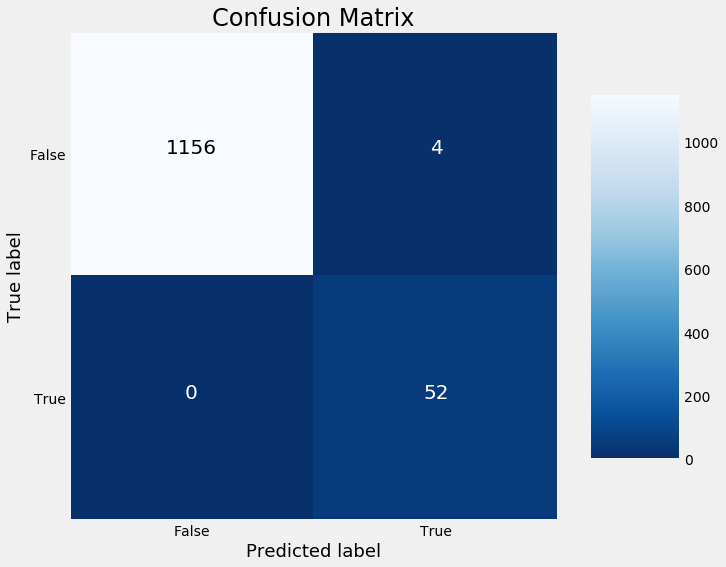

In [67]:
''' Confusion Matrix '''

classes = ['False', 'True']
df_cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(df_cm, interpolation='nearest', cmap="Blues_r")
plt.title('Confusion Matrix', size = 24)
plt.colorbar(aspect=4)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, size = 14)
plt.yticks(tick_marks, classes, size = 14)

thresh = df_cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, format(df_cm[i, j], 'd'), fontsize = 20,
                 horizontalalignment="center", color="black" if df_cm[i, j] > thresh else "white")
plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
plt.show()


## The Results

Our model suggests we set representatives in 52 settlements which is not a high number compared to the number of settlements we have which is 1214 